In [ ]:
!git clone https://github.com/michaelwwk/appStoreAnalytics.git

Cloning into 'appStoreAnalytics'...
remote: Enumerating objects: 3723, done.
remote: Counting objects: 100% (773/773), done.
remote: Compressing objects: 100% (278/278), done.
remote: Total 3723 (delta 475), reused 759 (delta 464), pack-reused 2950
Receiving objects: 100% (3723/3723), 397.29 MiB | 25.11 MiB/s, done.
Resolving deltas: 100% (2448/2448), done.
Updating files: 100% (73/73), done.


In [1]:
import pandas as pd
import json
from google.cloud import bigquery, storage
!pip install pyspark
from pyspark.sql import SparkSession

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=1f64f8a33844e38759285ef162b1d4ae9c8d7bde2b5ec2b65e99b8b74d116b1c
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
!apt-get install graphviz

In [2]:
from pyspark.sql.functions import split, explode
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from functools import reduce
from pyspark.sql.functions import col, when
from pyspark.sql import functions as F
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from graphviz import Source


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Start Spark session
spark = SparkSession.builder.master("local").appName("appStoreAnalytics").config('spark.ui.port', '4050').getOrCreate()

In [ ]:
# Define your BigQuery project ID and table ID
project_id = "big-data-analytics-415801"
table_id = 'cleanData.cleanGoogleMain'

# SQL query to fetch the data from the table
sql_query = f"SELECT * FROM {table_id}"

# Read data from BigQuery into a DataFrame
googleMain_pdDF = pd.read_gbq(sql_query, project_id=project_id)

In [ ]:
pd.set_option('display.max_columns', None)
googleMain_pdDF.head()

,title,description,summary,installs,minInstalls,realInstalls,score,ratings,reviews,price,free,currency,offersIAP,inAppProductPrice,developer,genre,genreId,contentRating,contentRatingDescription,adSupported,released,lastUpdatedOn,version,appId,categories_list,min_inAppProductPrice,max_inAppProductPrice,1starrating_no,2starrating_no,3starrating_no,4starrating_no,5starrating_no
0,Rooster Crowing Sound,This is a very simple rooster crowing sound ap...,A simple rooster crowing sound application,"1,000+",1000,3985,4.1666665,19,4,0.0,True,USD,False,None,Infinite_Apps,Tools,TOOLS,Mature 17+,None,True,"Jan 14, 2017","Oct 19, 2022",1.9,apps.infinite.cockadoodledoo,[Tools],None,None,3,0,0,3,12
1,Random Number,It is very simple but quite functional to gene...,Random Numer Generator!,100+,100,188,5.0,7,0,0.0,True,USD,False,None,CR-Eduardo-Vargas,Tools,TOOLS,Everyone,None,True,"Jun 11, 2019","Jun 20, 2019",1.5,com.lalixx.anuncio,[Tools],None,None,0,0,0,0,7
2,LC Circuit,This app is used to calculate LC resonant circ...,Find out combinations of L and C making a desi...,"10,000+",10000,27354,4.3589745,320,19,0.0,True,USD,True,$1.99 per item,Peter Ho,Tools,TOOLS,Everyone,None,True,"Jan 16, 2014","Aug 21, 2023",1.7.90,com.peterhohsy.lccircuit,[Tools],1.99,None,16,16,32,24,224
3,PSD EPS File Viewer,With Psd Eps file Viewer you easily preview an...,"View, convert to png and share PSD and EPS fil...","50,000+",50000,71667,2.45,191,11,0.0,True,USD,False,None,AwsomeApps,Tools,TOOLS,Everyone,None,True,"Nov 10, 2018","Dec 1, 2021",1.19,com.awasomapps.psdepsviewer,[Tools],None,None,105,9,9,19,47
4,ISHAN VPN,Ishan vpn is unlimited free and fast vpn appli...,One click connect and disconnect VPN,"100,000+",100000,351298,4.282051,3360,13,0.0,True,USD,True,$0.99 - $12.99 per item,ISHAN GURU,Tools,TOOLS,Everyone,None,True,"Jun 30, 2020","Oct 30, 2023",2.7,com.ishan.vpn.pro,[Tools],0.99,12.99,258,172,172,516,2240


# Read Data

**Read Data**

In [6]:
# googleMain_pdDF.to_csv("/content/drive/MyDrive/Colab Notebooks/cleanGoogleMain.csv")

# Read CSV files into PySpark DataFrame
googleMain_sparkDF = spark.read.format("csv") \
                    .option("inferSchema", "true") \
                    .option("header", "true") \
                    .option("multiline", "true") \
                    .option("escape", "\"") \
                    .csv("/content/drive/MyDrive/Colab Notebooks/cleanGoogleMain.csv")

In [ ]:
googleMain_sparkDF.show(10)

+---+--------------------+--------------------+--------------------+--------+-----------+------------+---------+-------+-------+-----+----+--------+---------+--------------------+--------------------+------+-------+-------------+------------------------+-----------+------------+-------------+-------+--------------------+---------------+---------------------+---------------------+--------------+--------------+--------------+--------------+--------------+
|_c0|               title|         description|             summary|installs|minInstalls|realInstalls|    score|ratings|reviews|price|free|currency|offersIAP|   inAppProductPrice|           developer| genre|genreId|contentRating|contentRatingDescription|adSupported|    released|lastUpdatedOn|version|               appId|categories_list|min_inAppProductPrice|max_inAppProductPrice|1starrating_no|2starrating_no|3starrating_no|4starrating_no|5starrating_no|
+---+--------------------+--------------------+--------------------+--------+-------

In [ ]:
googleMain_sparkDF.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- installs: string (nullable = true)
 |-- minInstalls: integer (nullable = true)
 |-- realInstalls: long (nullable = true)
 |-- score: double (nullable = true)
 |-- ratings: integer (nullable = true)
 |-- reviews: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- free: boolean (nullable = true)
 |-- currency: string (nullable = true)
 |-- offersIAP: boolean (nullable = true)
 |-- inAppProductPrice: string (nullable = true)
 |-- developer: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- genreId: string (nullable = true)
 |-- contentRating: string (nullable = true)
 |-- contentRatingDescription: string (nullable = true)
 |-- adSupported: boolean (nullable = true)
 |-- released: string (nullable = true)
 |-- lastUpdatedOn: string (nullable = true)
 |-- version: string (nullable = true)
 |-- a

# EDA

**EDA**

In [ ]:
# double check null values
# Define the columns
columns = [
    "title", "description", "summary", "installs", "minInstalls", "realInstalls",
    "score", "ratings", "reviews", "price", "free", "currency", "offersIAP",
    "inAppProductPrice", "developer", "genre", "genreId", "contentRating",
    "contentRatingDescription", "adSupported", "released", "lastUpdatedOn",
    "version", "appId", "categories_list", "min_inAppProductPrice",
    "max_inAppProductPrice", "1starrating_no", "2starrating_no",
    "3starrating_no", "4starrating_no", "5starrating_no"
]

# Define a function to count null values for a specific column
def count_nulls(column_name):
    return googleMain_sparkDF.filter(col(column_name).isNull()).count()

# Use map() to apply the function to each column and create a list of tuples (column_name, null_count)
null_counts = list(map(lambda column_name: (column_name, count_nulls(column_name)), columns))

# Print column names and their corresponding null counts
for col_name, null_count in null_counts:
    print(f"Column '{col_name}' has {null_count} null values.")


Column 'title' has 0 null values.
Column 'description' has 0 null values.
Column 'summary' has 0 null values.
Column 'installs' has 0 null values.
Column 'minInstalls' has 0 null values.
Column 'realInstalls' has 0 null values.
Column 'score' has 0 null values.
Column 'ratings' has 0 null values.
Column 'reviews' has 0 null values.
Column 'price' has 0 null values.
Column 'free' has 0 null values.
Column 'currency' has 0 null values.
Column 'offersIAP' has 0 null values.
Column 'inAppProductPrice' has 0 null values.
Column 'developer' has 0 null values.
Column 'genre' has 0 null values.
Column 'genreId' has 0 null values.
Column 'contentRating' has 0 null values.
Column 'contentRatingDescription' has 0 null values.
Column 'adSupported' has 0 null values.
Column 'released' has 0 null values.
Column 'lastUpdatedOn' has 0 null values.
Column 'version' has 0 null values.
Column 'appId' has 0 null values.
Column 'categories_list' has 0 null values.
Column 'min_inAppProductPrice' has 461904 

In [ ]:
# Check number of distinct values for categorical features

# Define the columns
columns = ['installs', 'developer', 'genre', 'contentRating', 'contentRatingDescription']

# Define a function to count the number of distinct values for a specific column
def count_distinct(column_name):
    return googleMain_sparkDF.select(column_name).distinct().count()

# Use map() to apply the function to each column and create a list of tuples (column_name, distinct_count)
distinct_counts = list(map(lambda column_name: (column_name, count_distinct(column_name)), columns))

# Print column names and their corresponding distinct counts
for col_name, distinct_count in distinct_counts:
    print(f"Column '{col_name}' has {distinct_count} distinct values.")

Column 'installs' has 19 distinct values.
Column 'developer' has 254145 distinct values.
Column 'genre' has 48 distinct values.
Column 'contentRating' has 6 distinct values.
Column 'contentRatingDescription' has 1102 distinct values.


In [ ]:
# Check distinct values for categorical features

# Define the columns
columns = ['installs', 'genre', 'contentRating', 'contentRatingDescription']

# Define a function to collect all distinct values for a specific column
def get_distinct_values(column_name):
    distinct_values = googleMain_sparkDF.select(column_name).distinct().rdd.map(lambda row: row[0]).collect()
    return column_name, distinct_values

# Use map() to apply the function to each column and create a list of tuples (column_name, distinct_values)
distinct_values_list = list(map(lambda column_name: get_distinct_values(column_name), columns))

# Print column names and their corresponding distinct values
for col_name, distinct_values in distinct_values_list:
    print(f"Column '{col_name}' has distinct values:")
    for value in distinct_values:
        print(value)
    print()  # Print an empty line for better readability

Column 'installs' has distinct values:
50,000+
100+
5,000,000+
100,000,000+
1,000,000,000+
1,000,000+
500,000,000+
10+
50+
5+
500+
1,000+
500,000+
5,000+
10,000,000+
50,000,000+
100,000+
1+
10,000+

Column 'genre' has distinct values:
Music & Audio
Education
Trivia
Auto & Vehicles
Entertainment
Adventure
Arcade
Sports
Travel & Local
Food & Drink
Role Playing
Finance
Personalization
Racing
Tools
Educational
Comics
Social
Libraries & Demo
Shopping
Health & Fitness
House & Home
Productivity
Card
Casino
Music
Photography
Events
Lifestyle
Business
News & Magazines
Video Players & Editors
Books & Reference
Dating
Weather
Puzzle
Casual
Board
Medical
Parenting
Word
Communication
Beauty
Action
Strategy
Maps & Navigation
Art & Design
Simulation

Column 'contentRating' has distinct values:
Unrated
Teen
Mature 17+
Everyone 10+
Everyone
Adults only 18+

Column 'contentRatingDescription' has distinct values:
Suggestive Themes, Nudity
Violent References, Tobacco Reference
Mild Violence, Use of Alcoho

In [ ]:
## Try to derive new attributes using contentRatingDescription
## Not using due to sparse dataset

from pyspark.sql.functions import split, when, lit, array_contains

# Define the column containing terms to be split
column_name = 'contentRatingDescription'

# Step 1: Split the contentRatingDescription column into separate terms
split_terms_df = googleMain_sparkDF.withColumn(column_name + '_split', split(col(column_name), ', '))

# Step 2: Collect distinct terms
distinct_terms = split_terms_df.select(explode(column_name + '_split')).distinct().rdd.map(lambda row: row[0]).collect()

# Step 3: Define one-hot encoding for each term
one_hot_exprs = [when(array_contains(col(column_name + '_split'), term), lit(1)).otherwise(lit(0)).alias(term.replace(' ', '_')) for term in distinct_terms]

# Step 4: Apply one-hot encoding to create separate columns
one_hot_encoded_df = split_terms_df.select("*", *one_hot_exprs)

# Show the resulting DataFrame
one_hot_encoded_df.show(truncate=False)


+---+------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Random forest using top 20 genres

**Random Forest**

Using top 20 genres

In [7]:
# Get the top 20 genres based on frequency
top_genres = googleMain_sparkDF.groupBy("genre").count().orderBy(col("count").desc()).limit(20)

# Collect the top 20 genres as a list
top_genre_list = top_genres.select("genre").rdd.flatMap(lambda x: x).collect()

# Create a new column 'grouped_genre' where top genres are kept and others are replaced with 'Others'
googleMain_sparkDF_with_grouped_genre = googleMain_sparkDF.withColumn("grouped_genre",
    when(col("genre").isin(top_genre_list), col("genre")).otherwise("Others")
)

# Show the DataFrame with the grouped genre column
googleMain_sparkDF_with_grouped_genre.select("genre", "grouped_genre").show()


+-------+-------------+
|  genre|grouped_genre|
+-------+-------------+
|  Tools|        Tools|
|  Tools|        Tools|
|  Tools|        Tools|
|  Tools|        Tools|
|  Tools|        Tools|
|  Tools|        Tools|
|  Tools|        Tools|
|  Tools|        Tools|
|  Tools|        Tools|
| Events|       Others|
| Social|       Others|
| Social|       Others|
| Social|       Others|
| Social|       Others|
| Social|       Others|
| Sports|       Sports|
| Sports|       Sports|
| Sports|       Sports|
| Sports|       Sports|
|Finance|      Finance|
+-------+-------------+
only showing top 20 rows



In [ ]:
print(top_genre_list)

['Education', 'Tools', 'Music & Audio', 'Books & Reference', 'Entertainment', 'Business', 'Lifestyle', 'Finance', 'Personalization', 'Productivity', 'Health & Fitness', 'Travel & Local', 'Shopping', 'Food & Drink', 'Sports', 'News & Magazines', 'Puzzle', 'Communication', 'Casual', 'Arcade']


In [ ]:
# Define your string columns and numeric columns
string_columns = ['grouped_genre',
                  'contentRating']
numeric_columns = ['score', 'ratings',
                   'reviews', 'price', '1starrating_no',
                   '2starrating_no', '3starrating_no', '4starrating_no',
                   '5starrating_no']

# Create StringIndexers for categorical string columns
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index").setHandleInvalid("keep")
            for col in string_columns]

# Function to apply StringIndexer to DataFrame
def apply_indexer(df, indexer):
    return indexer.fit(df).transform(df)

# Apply StringIndexers to DataFrame using reduce and functional composition
googleMain_sparkDF_index = reduce(apply_indexer, indexers, googleMain_sparkDF_with_grouped_genre)

In [ ]:
# Convert string labels into numerical labels
indexer = StringIndexer(inputCol="installs", outputCol="label")
googleMain_sparkDF_index = indexer.fit(googleMain_sparkDF_index).transform(googleMain_sparkDF_index)

In [ ]:
googleMain_sparkDF_index.head(10)

In [ ]:
# Create VectorAssembler to combine all feature columns into a single feature vector
assembler = VectorAssembler(
    inputCols=numeric_columns + [col+"_index" for col in ['grouped_genre', 'contentRating']],
    outputCol="features"
)

selected_data = assembler.transform(googleMain_sparkDF_index)

In [ ]:
# Split the data into training and testing sets
(training_data, testing_data) = selected_data.randomSplit([0.8, 0.2], seed=123)

In [ ]:
# Customized parameters
num_trees = 50
max_depth = 10

In [ ]:
# Define your RandomForestClassifier
rf = RandomForestClassifier(labelCol="label",
                            featuresCol="features",
                            numTrees=num_trees,
                            maxDepth=max_depth)

In [ ]:
# Fit the pipeline to your data
model = rf.fit(training_data)

In [ ]:
# Make predictions on the testing data
predictions = model.transform(testing_data)

In [ ]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

In [ ]:
# Print the accuracy
print("Accuracy: {:.2f}".format(accuracy))


Accuracy: 0.53


In [ ]:
predictions.head()

Row(_c0=2, title='LC Circuit', description='This app is used to calculate LC resonant circuit. It is suitable for hobbyist or electronic engineers. \r\n\r\n\r\nFeatures:</b>\r\n1. Calculate resonant frequency  by capacitor and inductor values\r\n2. To find out combinations of capacitance and inductance making a desired resonant frequency\r\n3. Save all combinations in a CSV (Excel) file \r\n4. Use preferred values of capacitors and inductors\r\n\r\n\r\nFeatures in PRO version only:</b>\r\n1. selectable preferred value  \r\n2. No Ads\r\n3. No limitation\r\n\r\n\r\nNote :</b>\r\n1. For those who need support please email to the designated email.\r\nDo NOT use either the feedback area to write questions, it is not appropriate and that is not guaranteed that can read them.', summary='Find out combinations of L and C making a desired resonant frequency', installs='10,000+', minInstalls=10000, realInstalls=27354, score=4.3589745, ratings=320, reviews=19, price=0.0, free=True, currency='USD',

# Random forest using 6 installs categories

**Random Forest**

Using 6 installs categories

In [ ]:
# Define the columns
columns = ['minInstalls']

# Define a function to collect all distinct values for a specific column
def get_distinct_values(column_name):
    distinct_values = googleMain_sparkDF_with_grouped_genre.select(column_name).distinct().rdd.map(lambda row: row[0]).collect()
    # Sort the distinct values in ascending order
    distinct_values.sort()
    return column_name, distinct_values

# Use map() to apply the function to each column and create a list of tuples (column_name, distinct_values)
distinct_values_list = list(map(lambda column_name: get_distinct_values(column_name), columns))

# Print column names and their corresponding distinct values
for col_name, distinct_values in distinct_values_list:
    print(f"Column '{col_name}' has distinct values:")
    for value in distinct_values:
        print(value)
    print()  # Print an empty line for better readability


Column 'minInstalls' has distinct values:
1
5
10
50
100
500
1000
5000
10000
50000
100000
500000
1000000
5000000
10000000
50000000
100000000
500000000
1000000000



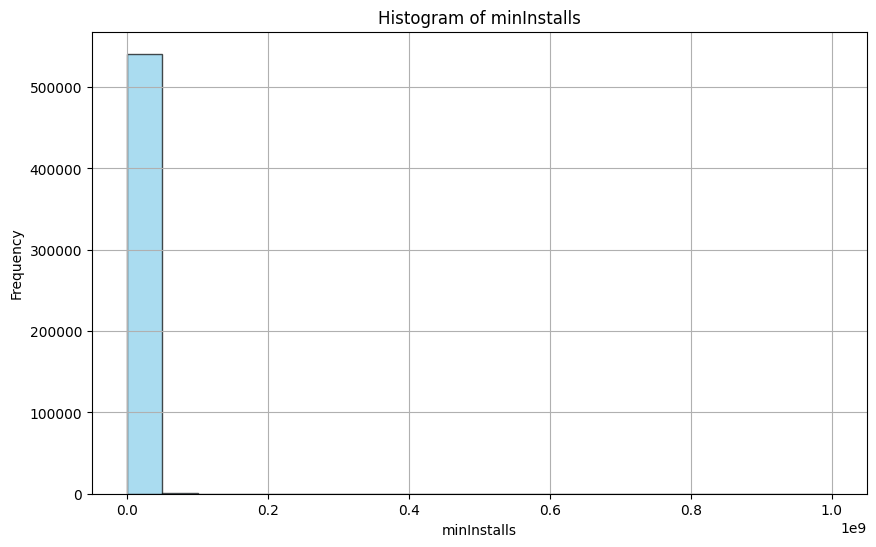

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the minInstalls column values as a list
min_installs_values = googleMain_sparkDF_with_grouped_genre.select('minInstalls').rdd.flatMap(lambda x: x).collect()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(min_installs_values, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of minInstalls')
plt.xlabel('minInstalls')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [ ]:
# Try to group into top 6 categories

# Define the categories and their thresholds
categories = {
    '0 to 1k': (0, 1000),
    '1k+ to 5k': (1001, 5000),
    '5k+ to 10k+': (5001, 10000),
    '10k+ to 50k': (10001, 50000),
    '50k+ to 100k': (50001, 100000),
    '100k+' : (100001, float('inf'))
}

# Create a case expression to map numeric installs to category labels
case_expr = (
    F.when((F.col('minInstalls') >= lower) & (F.col('minInstalls') <= upper), category)
    for category, (lower, upper) in categories.items()
)

In [ ]:
# Apply the case expression to create the new column 'minInstalls_category'
googleMain_sparkDF_v2 = googleMain_sparkDF_with_grouped_genre.withColumn(
    'minInstalls_category',
    F.coalesce(*case_expr, F.lit('Others'))
)

In [ ]:
googleMain_sparkDF_v2.head(10)

In [ ]:
# Define the categories and their thresholds
categories = {
    '0 to 1k': (0, 1000),
    '1k+ to 5k': (1001, 5000),
    '5k+ to 10k+': (5001, 10000),
    '10k+ to 50k': (10001, 50000),
    '50k+ to 100k': (50001, 100000),
    '100k+': (100001, float('inf'))
}

# Define a function to get the lower threshold for sorting
def get_lower_threshold(category):
    return categories[category][0]

# Group by the 'minInstalls_category' column and count the number of items
category_counts = (googleMain_sparkDF_v2
                   .groupBy('minInstalls_category')
                   .count()
                   .orderBy(F.udf(get_lower_threshold)('minInstalls_category'))
                   )

# Show the results
category_counts.show()


+--------------------+------+
|minInstalls_category| count|
+--------------------+------+
|             0 to 1k|222460|
|               100k+| 60772|
|         10k+ to 50k| 35651|
|           1k+ to 5k| 54286|
|        50k+ to 100k| 63863|
|         5k+ to 10k+|104886|
+--------------------+------+



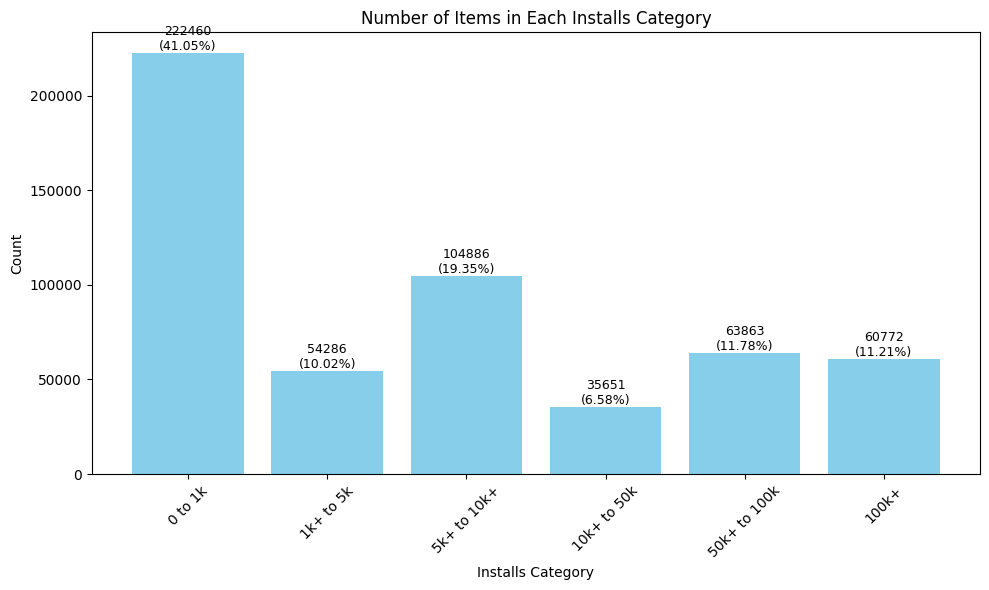

In [ ]:
# Convert DataFrame to Pandas for sorting
category_counts_pd = category_counts.toPandas()

# Sort the categories based on the lower threshold
category_counts_pd['sort_key'] = category_counts_pd['minInstalls_category'].apply(get_lower_threshold)
category_counts_pd_sorted = category_counts_pd.sort_values(by='sort_key')

# Define the total count
total_count = category_counts_pd['count'].sum()

# Plot the histogram
plt.figure(figsize=(10, 6))
bars = plt.bar(category_counts_pd_sorted['minInstalls_category'], category_counts_pd_sorted['count'], color='skyblue')
plt.xlabel('Installs Category')
plt.ylabel('Count')
plt.title('Number of Items in Each Installs Category')
plt.xticks(rotation=45)
# Annotate each bar with count and percentage
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_count) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}\n({percentage:.2f}%)',
             ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()

In [ ]:
# Print the schema of the DataFrame
googleMain_sparkDF_v2.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- installs: string (nullable = true)
 |-- minInstalls: integer (nullable = true)
 |-- realInstalls: long (nullable = true)
 |-- score: double (nullable = true)
 |-- ratings: integer (nullable = true)
 |-- reviews: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- free: boolean (nullable = true)
 |-- currency: string (nullable = true)
 |-- offersIAP: boolean (nullable = true)
 |-- inAppProductPrice: string (nullable = true)
 |-- developer: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- genreId: string (nullable = true)
 |-- contentRating: string (nullable = true)
 |-- contentRatingDescription: string (nullable = true)
 |-- adSupported: boolean (nullable = true)
 |-- released: string (nullable = true)
 |-- lastUpdatedOn: string (nullable = true)
 |-- version: string (nullable = true)
 |-- a

In [ ]:
# Define your string columns and numeric columns
string_columns = ['grouped_genre',
                  'contentRating']
numeric_columns = ['score', 'ratings',
                   'reviews', 'price', '1starrating_no',
                   '2starrating_no', '3starrating_no', '4starrating_no',
                   '5starrating_no']

# Create StringIndexers for categorical string columns
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index").setHandleInvalid("keep")
            for col in string_columns]

# Function to apply StringIndexer to DataFrame
def apply_indexer(df, indexer):
    return indexer.fit(df).transform(df)

# Apply StringIndexers to DataFrame using reduce and functional composition
googleMain_sparkDF_v2_index = reduce(apply_indexer, indexers, googleMain_sparkDF_v2)

In [ ]:
# Define the boolean columns
boolean_columns = ['free', 'offersIAP', 'adSupported']

# Convert boolean columns to numeric form using when function
conversion_exprs = [when(col(col_name), 1).otherwise(0).alias(col_name + "_index") for col_name in boolean_columns]

# Apply the conversion expressions to the DataFrame
googleMain_sparkDF_v2_index = googleMain_sparkDF_v2_index.select("*", *conversion_exprs)

In [ ]:
# Convert string labels into numerical labels
indexer = StringIndexer(inputCol="minInstalls_category", outputCol="label")
googleMain_sparkDF_v2_index = indexer.fit(googleMain_sparkDF_v2_index).transform(googleMain_sparkDF_v2_index)

In [ ]:
googleMain_sparkDF_v2_index.head(1)

[Row(_c0=0, title='Rooster Crowing Sound', description='This is a very simple rooster crowing sound application\r\n\r\nDo you want to wake someone up with something natural and different? Or you just want to surprise people around you with a loud voice? Well we have this rooster crowing sound application just for you\r\n\r\nWith this rooster crowing sound application, you can:\r\n- Wake people around you with a Cock A Doodle Doo sound\r\n- Add sound effect to something that needs rooster crowing sound\r\n- Any other applications you can think of using the loud sound\r\n\r\nI hope you enjoy using this rooster crowing sound application!', summary='A simple rooster crowing sound application', installs='1,000+', minInstalls=1000, realInstalls=3985, score=4.1666665, ratings=19, reviews=4, price=0.0, free=True, currency='USD', offersIAP=False, inAppProductPrice='None', developer='Infinite_Apps', genre='Tools', genreId='TOOLS', contentRating='Mature 17+', contentRatingDescription='None', adSu

In [ ]:
# Create VectorAssembler to combine all feature columns into a single feature vector
assembler = VectorAssembler(
    inputCols=numeric_columns + [col+"_index" for col in ['grouped_genre', 'contentRating']] + boolean_columns,
    outputCol="features"
)

selected_data = assembler.transform(googleMain_sparkDF_v2_index)

In [ ]:
# Split the data into training and testing sets
(training_data, testing_data) = selected_data.randomSplit([0.8, 0.2], seed=123)

In [ ]:
# Customized parameters
num_trees = 50
max_depth = 10

In [ ]:
# Define your RandomForestClassifier
rf = RandomForestClassifier(labelCol="label",
                            featuresCol="features",
                            numTrees=num_trees,
                            maxDepth=max_depth)

In [ ]:
# Fit the pipeline to your data
model = rf.fit(training_data)

In [ ]:
# Make predictions on the testing data
predictions = model.transform(testing_data)

In [ ]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

In [ ]:
# Print the accuracy
print("Accuracy: {:.4f}".format(accuracy))

# Calculate precision
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedPrecision"
)
precision = precision_evaluator.evaluate(predictions)

# Calculate recall
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedRecall"
)
recall = recall_evaluator.evaluate(predictions)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))

Accuracy: 0.7201
Precision: 0.6826
Recall: 0.7201
F1-score: 0.7008


# Random forest using different parameters

**Random Forest**
Using different parameters

In [ ]:
# Customized parameters
num_trees = 30
max_depth = 10

# Define your RandomForestClassifier
rf = RandomForestClassifier(labelCol="label",
                            featuresCol="features",
                            numTrees=num_trees,
                            maxDepth=max_depth)

# Fit the pipeline to your data
model = rf.fit(training_data)

# Make predictions on the testing data
predictions = model.transform(testing_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Print the accuracy
print("Accuracy: {:.4f}".format(accuracy))

# Calculate precision
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedPrecision"
)
precision = precision_evaluator.evaluate(predictions)

# Calculate recall
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedRecall"
)
recall = recall_evaluator.evaluate(predictions)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))


Accuracy: 0.7194
Precision: 0.6786
Recall: 0.7194
F1-score: 0.6984


In [ ]:
# Customized parameters
num_trees = 50
max_depth = 8

# Define your RandomForestClassifier
rf = RandomForestClassifier(labelCol="label",
                            featuresCol="features",
                            numTrees=num_trees,
                            maxDepth=max_depth)

# Fit the pipeline to your data
model = rf.fit(training_data)

# Make predictions on the testing data
predictions = model.transform(testing_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Print the accuracy
print("Accuracy: {:.4f}".format(accuracy))

# Calculate precision
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedPrecision"
)
precision = precision_evaluator.evaluate(predictions)

# Calculate recall
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedRecall"
)
recall = recall_evaluator.evaluate(predictions)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))


Accuracy: 0.7142
Precision: 0.6425
Recall: 0.7142
F1-score: 0.6765


In [ ]:
# Customized parameters
num_trees = 80
max_depth = 10

# Define your RandomForestClassifier
rf = RandomForestClassifier(labelCol="label",
                            featuresCol="features",
                            numTrees=num_trees,
                            maxDepth=max_depth)

# Fit the pipeline to your data
model = rf.fit(training_data)

# Make predictions on the testing data
predictions = model.transform(testing_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Print the accuracy
print("Accuracy: {:.4f}".format(accuracy))

# Calculate precision
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedPrecision"
)
precision = precision_evaluator.evaluate(predictions)

# Calculate recall
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedRecall"
)
recall = recall_evaluator.evaluate(predictions)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))


Accuracy: 0.7201
Precision: 0.6841
Recall: 0.7201
F1-score: 0.7017


In [ ]:
# Customized parameters
num_trees = 100
max_depth = 10

# Define your RandomForestClassifier
rf = RandomForestClassifier(labelCol="label",
                            featuresCol="features",
                            numTrees=num_trees,
                            maxDepth=max_depth)

# Fit the pipeline to your data
model = rf.fit(training_data)

# Make predictions on the testing data
predictions = model.transform(testing_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Print the accuracy
print("Accuracy: {:.4f}".format(accuracy))

# Calculate precision
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedPrecision"
)
precision = precision_evaluator.evaluate(predictions)

# Calculate recall
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedRecall"
)
recall = recall_evaluator.evaluate(predictions)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))


Accuracy: 0.7197
Precision: 0.6835
Recall: 0.7197
F1-score: 0.7011


In [ ]:
# Customized parameters
num_trees = 100
max_depth = 10

# Define your RandomForestClassifier
rf = RandomForestClassifier(labelCol="label",
                            featuresCol="features",
                            numTrees=num_trees,
                            maxDepth=max_depth,
                            subsamplingRate=0.8)

# Fit the pipeline to your data
model = rf.fit(training_data)

# Make predictions on the testing data
predictions = model.transform(testing_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Print the accuracy
print("Accuracy: {:.4f}".format(accuracy))

# Calculate precision
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedPrecision"
)
precision = precision_evaluator.evaluate(predictions)

# Calculate recall
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedRecall"
)
recall = recall_evaluator.evaluate(predictions)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))


Accuracy: 0.7198
Precision: 0.6802
Recall: 0.7198
F1-score: 0.6994


# Feature selection for random forest

End

**Feature selection for Random Forest**

In [ ]:
## To use this Univariate Feature Selection, need to run indexer & vector assembler above + scaler below

In [ ]:
# Scale features using StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
scaler_model = scaler.fit(selected_data)
scaled_data = scaler_model.transform(selected_data)


In [ ]:
# Define the ChiSqSelector
selector = ChiSqSelector(numTopFeatures=8, featuresCol="scaledFeatures",
                         outputCol="selectedFeatures", labelCol="label")

# Fit the selector to the data
selector_model = selector.fit(scaled_data)

# Apply the selector to the data
selected_data = selector_model.transform(scaled_data)

# Get the selected features
selected_features = selector_model.selectedFeatures

In [ ]:
# Run random forest model using the selected features

# MLP

**MLP**

In [ ]:
# Define the layers for the Multilayer Perceptron classifier
input_size = len(numeric_columns) + len(string_columns) + len(boolean_columns)
layers = [input_size, 64, 32, 6]  # Input size, two hidden layers, output size (number of classes)

# Define the Multilayer Perceptron classifier
mlp = MultilayerPerceptronClassifier(layers=layers, seed=1234, labelCol="label", featuresCol="features")

# Train the model
model = mlp.fit(training_data)

# Make predictions
predictions = model.transform(testing_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})

# Precision
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})

# Recall
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# F1-score
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

# Print evaluation metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))

Accuracy: 0.6877
Precision: 0.5980
Recall: 0.6877
F1-score: 0.6265


In [ ]:
# Define the layers for the Multilayer Perceptron classifier
input_size = len(numeric_columns) + len(string_columns) + len(boolean_columns)
layers = [input_size, 32, 16, 6]  # Input size, two hidden layers, output size (number of classes)

# Define the Multilayer Perceptron classifier
mlp = MultilayerPerceptronClassifier(layers=layers, seed=1234, labelCol="label", featuresCol="features")

# Train the model
model = mlp.fit(training_data)

# Make predictions
predictions = model.transform(testing_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})

# Precision
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})

# Recall
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# F1-score
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

# Print evaluation metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))

Accuracy: 0.6832
Precision: 0.6104
Recall: 0.6832
F1-score: 0.6268


In [ ]:
# Define the layers for the Multilayer Perceptron classifier
input_size = len(numeric_columns) + len(string_columns) + len(boolean_columns)
layers = [input_size, 64, 32, 16, 6]  # Input size, two hidden layers, output size (number of classes)

# Define the Multilayer Perceptron classifier
mlp = MultilayerPerceptronClassifier(layers=layers, seed=1234, labelCol="label", featuresCol="features")

# Train the model
model = mlp.fit(training_data)

# Make predictions
predictions = model.transform(testing_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})

# Precision
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})

# Recall
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# F1-score
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

# Print evaluation metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))

Accuracy: 0.6843
Precision: 0.6210
Recall: 0.6843
F1-score: 0.6399


# MLP using scaled data

**MLP using Scaled Data**

In [ ]:
# Define columns
categorical_columns = ['grouped_genre',
                  'contentRating']
numeric_columns = ['score', 'ratings',
                   'reviews', 'price', '1starrating_no',
                   '2starrating_no', '3starrating_no', '4starrating_no',
                   '5starrating_no']
boolean_columns = ['free', 'offersIAP', 'adSupported']
output_column = 'minInstalls_category'

# StringIndexer for the output column
label_indexer = StringIndexer(inputCol=output_column, outputCol="label")

# Define preprocessing stages for numeric features
numeric_assemblers = [
    VectorAssembler(inputCols=[col], outputCol=col + "_vector") for col in numeric_columns
]

# Combine all numeric vectors into a single vector
numeric_vector_assembler = VectorAssembler(inputCols=[col + "_vector" for col in numeric_columns],
                                           outputCol="numeric_features")

# Define StandardScaler for numeric features
scaler = StandardScaler(inputCol="numeric_features", outputCol="scaled_features", withMean=True, withStd=True)

# Define preprocessing stages for categorical features
categorical_indexers = [
    StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep")
    for col in categorical_columns
]

# Convert boolean columns to numeric form using when function
conversion_exprs = {col_name: when(col(col_name), 1).otherwise(0).alias(col_name + "_index") for col_name in boolean_columns}

# Apply boolean column conversion
googleMain_sparkDF_v3 = googleMain_sparkDF_v2.withColumns(conversion_exprs)

# Define feature vector assembler
feature_columns = ["scaled_features"] + [col + "_index" for col in categorical_columns] + boolean_columns
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Apply all preprocessing stages
pipeline_stages = [label_indexer] + numeric_assemblers + [numeric_vector_assembler] + [scaler] + categorical_indexers + [assembler]

# Define the pipeline
pipeline = Pipeline(stages=pipeline_stages)

# Fit the pipeline to the data
googleMain_sparkDF_v3 = pipeline.fit(googleMain_sparkDF_v3).transform(googleMain_sparkDF_v3)

# Show the transformed DataFrame
googleMain_sparkDF_v3.show()

+---+----------------------------+--------------------+--------------------+----------+-----------+------------+---------+-------+-------+-----+----+--------+---------+--------------------+--------------------+-------+-------+-------------+------------------------+-----------+------------+-------------+-------+--------------------+---------------+---------------------+---------------------+--------------+--------------+--------------+--------------+--------------+-------------+--------------------+-----+------------+--------------+--------------+------------+---------------------+---------------------+---------------------+---------------------+---------------------+--------------------+--------------------+-------------------+-------------------+--------------------+
|_c0|                       title|         description|             summary|  installs|minInstalls|realInstalls|    score|ratings|reviews|price|free|currency|offersIAP|   inAppProductPrice|           developer|  genre|gen

In [ ]:
# Split data into training and test sets
(training_data, testing_data) = googleMain_sparkDF_v3.randomSplit([0.8, 0.2], seed=123)

In [ ]:
# Define the layers for the Multilayer Perceptron classifier
input_size = len(numeric_columns) + len(string_columns) + len(boolean_columns)
layers = [input_size, 32, 16, 6]  # Input size, two hidden layers, output size (number of classes)

# Define the Multilayer Perceptron classifier
mlp = MultilayerPerceptronClassifier(layers=layers, seed=1234, labelCol="label", featuresCol="features")

# Train the model
model = mlp.fit(training_data)

# Make predictions
predictions = model.transform(testing_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})

# Precision
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})

# Recall
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# F1-score
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

# Print evaluation metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))

Accuracy: 0.5211
Precision: 0.3971
Recall: 0.5211
F1-score: 0.4052


In [ ]:
# Define the layers for the Multilayer Perceptron classifier
input_size = len(numeric_columns) + len(string_columns) + len(boolean_columns)
layers = [input_size, 64, 32, 6]  # Input size, two hidden layers, output size (number of classes)

# Define the Multilayer Perceptron classifier
mlp = MultilayerPerceptronClassifier(layers=layers, seed=1234, labelCol="label", featuresCol="features")

# Train the model
model = mlp.fit(training_data)

# Make predictions
predictions = model.transform(testing_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})

# Precision
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})

# Recall
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# F1-score
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

# Print evaluation metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))

Accuracy: 0.5268
Precision: 0.4119
Recall: 0.5268
F1-score: 0.4433


# Decision Tree

**Decison Tree**

In [ ]:
## Not using scaled data - use the normal data as per random forest

# Train a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=20)
dt_model = dt_classifier.fit(training_data)

# Make predictions on the testing data
predictions = dt_model.transform(testing_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Calculate accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print("Accuracy:", accuracy)

# Calculate precision
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
print("Precision:", precision)

# Calculate recall
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
print("Recall:", recall)

# Calculate F1-score
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print("F1-score:", f1_score)

Accuracy: 0.6747826886814147
Precision: 0.6605890231859451
Recall: 0.6747826886814147
F1-score: 0.6663299967997731


In [ ]:
# Train a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=30)
dt_model = dt_classifier.fit(training_data)

# Make predictions on the testing data
predictions = dt_model.transform(testing_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Calculate accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print("Accuracy:", accuracy)

# Calculate precision
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
print("Precision:", precision)

# Calculate recall
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
print("Recall:", recall)

# Calculate F1-score
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print("F1-score:", f1_score)

Accuracy: 0.6420273191371936
Precision: 0.6401442467851863
Recall: 0.6420273191371936
F1-score: 0.6410655143665884


In [ ]:
# Train a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=15)
dt_model = dt_classifier.fit(training_data)

# Make predictions on the testing data
predictions = dt_model.transform(testing_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Calculate accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print("Accuracy:", accuracy)

# Calculate precision
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
print("Precision:", precision)

# Calculate recall
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
print("Recall:", recall)

# Calculate F1-score
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print("F1-score:", f1_score)

Accuracy: 0.705413236443913
Precision: 0.6791444743958865
Recall: 0.7054132364439131
F1-score: 0.6856189704849263


In [ ]:
# Train a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=10)
dt_model = dt_classifier.fit(training_data)

# Make predictions on the testing data
predictions = dt_model.transform(testing_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Calculate accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print("Accuracy:", accuracy)

# Calculate precision
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
print("Precision:", precision)

# Calculate recall
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
print("Recall:", recall)

# Calculate F1-score
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print("F1-score:", f1_score)

Accuracy: 0.7169295865335971
Precision: 0.6827577244177349
Recall: 0.716929586533597
F1-score: 0.683326006325246


In [ ]:
# Train a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=8)
dt_model = dt_classifier.fit(training_data)

# Make predictions on the testing data
predictions = dt_model.transform(testing_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Calculate accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print("Accuracy:", accuracy)

# Calculate precision
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
print("Precision:", precision)

# Calculate recall
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
print("Recall:", recall)

# Calculate F1-score
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print("F1-score:", f1_score)

Accuracy: 0.7130938692912662
Precision: 0.6794120053930308
Recall: 0.7130938692912661
F1-score: 0.6764510835883532


In [ ]:
# Train a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=12)
dt_model = dt_classifier.fit(training_data)

# Make predictions on the testing data
predictions = dt_model.transform(testing_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Calculate accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print("Accuracy:", accuracy)

# Calculate precision
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
print("Precision:", precision)

# Calculate recall
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
print("Recall:", recall)

# Calculate F1-score
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print("F1-score:", f1_score)

Accuracy: 0.7179965966058042
Precision: 0.6859564781091545
Recall: 0.7179965966058042
F1-score: 0.6882984002831648


In [ ]:
# Extract feature names from the training data
feature_names = assembler.getInputCols()

# Get feature importance
feature_importance = dt_model.featureImportances.toArray()

# Create a list of (feature_index, importance) tuples
indexed_importance = [(i, importance) for i, importance in enumerate(feature_importance)]

# Sort the list by importance (descending)
sorted_importance = sorted(indexed_importance, key=lambda x: x[1], reverse=True)

# Print the feature importance in descending order
print("Feature Importance:")
for i, importance in sorted_importance:
    print(f"Feature '{feature_names[i]}': Importance - {importance}")


Feature Importance:
Feature 'ratings': Importance - 0.8496609539649337
Feature '1starrating_no': Importance - 0.03860760613617008
Feature 'score': Importance - 0.023852548762048363
Feature 'adSupported': Importance - 0.019151879515988436
Feature 'grouped_genre_index': Importance - 0.017612916312505337
Feature 'reviews': Importance - 0.015233546380361585
Feature 'free': Importance - 0.012976038757767453
Feature 'price': Importance - 0.006589790139567702
Feature '3starrating_no': Importance - 0.005205654856098746
Feature '4starrating_no': Importance - 0.0034419618204607504
Feature '5starrating_no': Importance - 0.003406423727493639
Feature '2starrating_no': Importance - 0.0025978551922477573
Feature 'contentRating_index': Importance - 0.000981064858707756
Feature 'offersIAP': Importance - 0.000681759575648522


In [ ]:
# Extract the decision tree model from the fitted model
dt_model = dt_model.bestModel if hasattr(dt_model, 'bestModel') else dt_model
decision_tree_model = dt_model.stages[-1]

# Convert the decision tree model to DOT format
dot_representation = decision_tree_model.toDebugString

# Save the DOT representation to a file
with open("/content/decision_tree.dot", "w") as file:
    file.write(dot_representation)

# Visualize the decision tree using Graphviz
Source(dot_representation)

# Rebuild using app characteristics only

**Rebuild using App Characteristics only**

In [ ]:
# Define your string columns and numeric columns
string_columns = ['grouped_genre',
                  'contentRating']
numeric_columns = ['price', 'score']

# Create StringIndexers for categorical string columns
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index").setHandleInvalid("keep")
            for col in string_columns]

# Function to apply StringIndexer to DataFrame
def apply_indexer(df, indexer):
    return indexer.fit(df).transform(df)

# Apply StringIndexers to DataFrame using reduce and functional composition
googleMain_sparkDF_v4_index = reduce(apply_indexer, indexers, googleMain_sparkDF_v2)

# Define the boolean columns
boolean_columns = ['free', 'offersIAP', 'adSupported']

# Convert boolean columns to numeric form using when function
conversion_exprs = [when(col(col_name), 1).otherwise(0).alias(col_name + "_index") for col_name in boolean_columns]

# Apply the conversion expressions to the DataFrame
googleMain_sparkDF_v4_index = googleMain_sparkDF_v4_index.select("*", *conversion_exprs)

# Convert string labels into numerical labels
indexer = StringIndexer(inputCol="minInstalls_category", outputCol="label")
googleMain_sparkDF_v4_index = indexer.fit(googleMain_sparkDF_v4_index).transform(googleMain_sparkDF_v4_index)

googleMain_sparkDF_v4_index.show(10)


+---+--------------------+--------------------+--------------------+--------+-----------+------------+---------+-------+-------+-----+----+--------+---------+--------------------+--------------------+------+-------+-------------+------------------------+-----------+------------+-------------+-------+--------------------+---------------+---------------------+---------------------+--------------+--------------+--------------+--------------+--------------+-------------+--------------------+-------------------+-------------------+----------+---------------+-----------------+-----+
|_c0|               title|         description|             summary|installs|minInstalls|realInstalls|    score|ratings|reviews|price|free|currency|offersIAP|   inAppProductPrice|           developer| genre|genreId|contentRating|contentRatingDescription|adSupported|    released|lastUpdatedOn|version|               appId|categories_list|min_inAppProductPrice|max_inAppProductPrice|1starrating_no|2starrating_no|3sta

In [ ]:
googleMain_sparkDF_v4_index.select(numeric_columns)

DataFrame[price: double, score: double]

In [ ]:
googleMain_sparkDF_v4_index.select([col+"_index" for col in string_columns])

DataFrame[grouped_genre_index: double, contentRating_index: double]

In [ ]:
googleMain_sparkDF_v4_index.select([col+"_index" for col in boolean_columns])

DataFrame[free_index: int, offersIAP_index: int, adSupported_index: int]

In [ ]:
# Create VectorAssembler to combine all feature columns into a single feature vector
assembler = VectorAssembler(
    inputCols=numeric_columns + [col+"_index" for col in string_columns] + [col+"_index" for col in boolean_columns],
    outputCol="features"
)

selected_data = assembler.transform(googleMain_sparkDF_v4_index)

# Split the data into training and testing sets
(training_data, testing_data) = selected_data.randomSplit([0.8, 0.2], seed=123)

In [ ]:
selected_data.show(20)

+---+----------------------------+--------------------+--------------------+----------+-----------+------------+---------+-------+-------+-----+----+--------+---------+--------------------+--------------------+-------+-------+-------------+------------------------+-----------+------------+-------------+-------+--------------------+---------------+---------------------+---------------------+--------------+--------------+--------------+--------------+--------------+-------------+--------------------+-------------------+-------------------+----------+---------------+-----------------+-----+--------------------+
|_c0|                       title|         description|             summary|  installs|minInstalls|realInstalls|    score|ratings|reviews|price|free|currency|offersIAP|   inAppProductPrice|           developer|  genre|genreId|contentRating|contentRatingDescription|adSupported|    released|lastUpdatedOn|version|               appId|categories_list|min_inAppProductPrice|max_inAppProd

In [ ]:
# Train a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=12)
dt_model = dt_classifier.fit(training_data)

# Make predictions on the testing data
predictions = dt_model.transform(testing_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Calculate accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print("Accuracy:", accuracy)

# Calculate precision
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
print("Precision:", precision)

# Calculate recall
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
print("Recall:", recall)

# Calculate F1-score
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print("F1-score:", f1_score)

Accuracy: 0.45624798785816123
Precision: 0.3506379027360996
Recall: 0.4562479878581613
F1-score: 0.3666802091686496


In [ ]:
# Extract feature names from the training data
feature_names = assembler.getInputCols()

# Get feature importance
feature_importance = dt_model.featureImportances.toArray()

# Create a list of (feature_index, importance) tuples
indexed_importance = [(i, importance) for i, importance in enumerate(feature_importance)]

# Sort the list by importance (descending)
sorted_importance = sorted(indexed_importance, key=lambda x: x[1], reverse=True)

# Print the feature importance in descending order
print("Feature Importance:")
for i, importance in sorted_importance:
    print(f"Feature '{feature_names[i]}': Importance - {importance}")


Feature Importance:
Feature 'score': Importance - 0.4157744018118519
Feature 'offersIAP_index': Importance - 0.22667350244639584
Feature 'grouped_genre_index': Importance - 0.18287657299847956
Feature 'adSupported_index': Importance - 0.12736165365942537
Feature 'contentRating_index': Importance - 0.0238672671925828
Feature 'price': Importance - 0.019062533302841238
Feature 'free_index': Importance - 0.004384068588423227


In [ ]:
# Visualize the decision tree
print(dt_model.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_37cc7b11ac52, depth=12, numNodes=3053, numClasses=6, numFeatures=7
  If (feature 1 <= 4.77250245)
   If (feature 5 <= 0.5)
    If (feature 6 <= 0.5)
     If (feature 1 <= 4.33234725)
      If (feature 2 in {1.0,6.0,14.0,15.0,16.0})
       If (feature 2 in {1.0,14.0})
        If (feature 1 <= 3.5981651)
         If (feature 0 <= 0.245)
          If (feature 1 <= 2.9591666500000002)
           If (feature 2 in {14.0})
            Predict: 0.0
           Else (feature 2 not in {14.0})
            If (feature 1 <= 2.1392695)
             Predict: 0.0
            Else (feature 1 > 2.1392695)
             If (feature 3 in {2.0})
              Predict: 4.0
             Else (feature 3 not in {2.0})
              Predict: 0.0
          Else (feature 1 > 2.9591666500000002)
           If (feature 3 in {0.0,1.0})
            Predict: 0.0
           Else (feature 3 not in {0.0,1.0})
            If (feature 1 <= 3.1649011)
             If

In [ ]:
# Customized parameters
num_trees = 100
max_depth = 10

# Define your RandomForestClassifier
rf = RandomForestClassifier(labelCol="label",
                            featuresCol="features",
                            numTrees=num_trees,
                            maxDepth=max_depth)

# Fit the pipeline to your data
model = rf.fit(training_data)

# Make predictions on the testing data
predictions = model.transform(testing_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Print the accuracy
print("Accuracy: {:.4f}".format(accuracy))

# Calculate precision
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedPrecision"
)
precision = precision_evaluator.evaluate(predictions)

# Calculate recall
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedRecall"
)
recall = recall_evaluator.evaluate(predictions)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))


Accuracy: 0.4555
Precision: 0.3274
Recall: 0.4555
F1-score: 0.3809


# Rebuild random forest using 2 output categories

**Using 2 categories**

In [8]:
# Try to group into 2 categories

# Define the categories and their thresholds
categories = {
    '0 to 10k': (0, 10000),
    '10k+': (10001, float('inf'))
}

# Create a case expression to map numeric installs to category labels
case_expr = (
    F.when((F.col('minInstalls') >= lower) & (F.col('minInstalls') <= upper), category)
    for category, (lower, upper) in categories.items()
)

In [9]:
# Apply the case expression to create the new column 'minInstalls_category'
googleMain_sparkDF_v2 = googleMain_sparkDF_with_grouped_genre.withColumn(
    'minInstalls_category',
    F.coalesce(*case_expr, F.lit('Others'))
)

In [ ]:
# Define a function to get the lower threshold for sorting
def get_lower_threshold(category):
    return categories[category][0]

# Group by the 'minInstalls_category' column and count the number of items
category_counts = (googleMain_sparkDF_v2
                   .groupBy('minInstalls_category')
                   .count()
                   .orderBy(F.udf(get_lower_threshold)('minInstalls_category'))
                   )

# Show the results
category_counts.show()

+--------------------+------+
|minInstalls_category| count|
+--------------------+------+
|            0 to 10k|381632|
|                10k+|160286|
+--------------------+------+



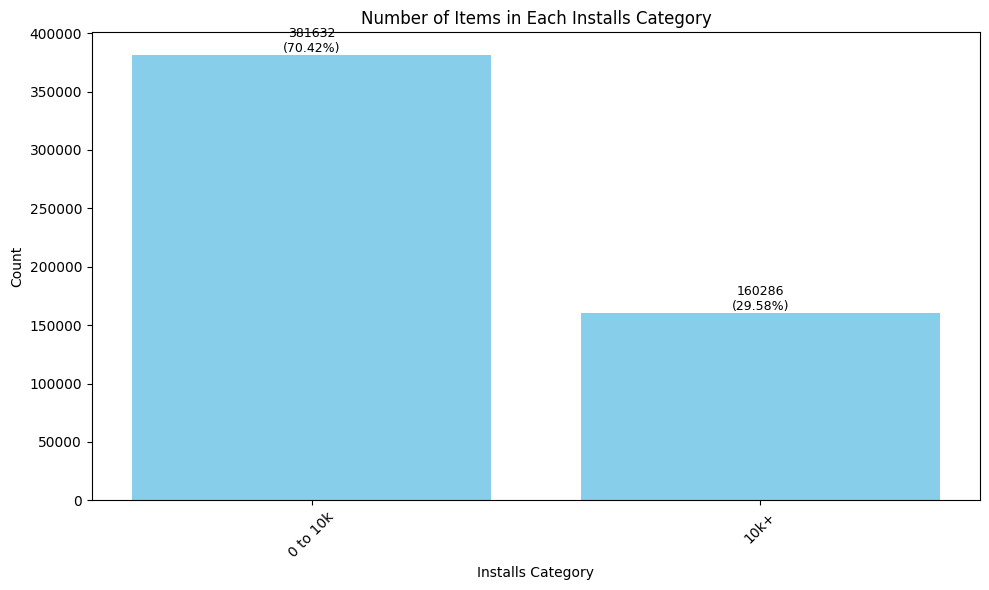

In [ ]:
# Convert DataFrame to Pandas for sorting
category_counts_pd = category_counts.toPandas()

# Sort the categories based on the lower threshold
category_counts_pd['sort_key'] = category_counts_pd['minInstalls_category'].apply(get_lower_threshold)
category_counts_pd_sorted = category_counts_pd.sort_values(by='sort_key')

# Define the total count
total_count = category_counts_pd['count'].sum()

# Plot the histogram
plt.figure(figsize=(10, 6))
bars = plt.bar(category_counts_pd_sorted['minInstalls_category'], category_counts_pd_sorted['count'], color='skyblue')
plt.xlabel('Installs Category')
plt.ylabel('Count')
plt.title('Number of Items in Each Installs Category')
plt.xticks(rotation=45)
# Annotate each bar with count and percentage
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_count) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}\n({percentage:.2f}%)',
             ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()

In [ ]:
# Define your string columns and numeric columns
string_columns = ['grouped_genre',
                  'contentRating']
numeric_columns = ['score', 'price']

# Create StringIndexers for categorical string columns
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index").setHandleInvalid("keep")
            for col in string_columns]

# Function to apply StringIndexer to DataFrame
def apply_indexer(df, indexer):
    return indexer.fit(df).transform(df)

# Apply StringIndexers to DataFrame using reduce and functional composition
googleMain_sparkDF_v2_index = reduce(apply_indexer, indexers, googleMain_sparkDF_v2)

In [ ]:
# Define the boolean columns
boolean_columns = ['free', 'offersIAP', 'adSupported']

# Convert boolean columns to numeric form using when function
conversion_exprs = [when(col(col_name), 1).otherwise(0).alias(col_name + "_index") for col_name in boolean_columns]

# Apply the conversion expressions to the DataFrame
googleMain_sparkDF_v2_index = googleMain_sparkDF_v2_index.select("*", *conversion_exprs)

In [ ]:
# Convert string labels into numerical labels
indexer = StringIndexer(inputCol="minInstalls_category", outputCol="label")
googleMain_sparkDF_v2_index = indexer.fit(googleMain_sparkDF_v2_index).transform(googleMain_sparkDF_v2_index)

In [ ]:
googleMain_sparkDF_v2_index.head(1)

[Row(_c0=0, title='Rooster Crowing Sound', description='This is a very simple rooster crowing sound application\r\n\r\nDo you want to wake someone up with something natural and different? Or you just want to surprise people around you with a loud voice? Well we have this rooster crowing sound application just for you\r\n\r\nWith this rooster crowing sound application, you can:\r\n- Wake people around you with a Cock A Doodle Doo sound\r\n- Add sound effect to something that needs rooster crowing sound\r\n- Any other applications you can think of using the loud sound\r\n\r\nI hope you enjoy using this rooster crowing sound application!', summary='A simple rooster crowing sound application', installs='1,000+', minInstalls=1000, realInstalls=3985, score=4.1666665, ratings=19, reviews=4, price=0.0, free=True, currency='USD', offersIAP=False, inAppProductPrice='None', developer='Infinite_Apps', genre='Tools', genreId='TOOLS', contentRating='Mature 17+', contentRatingDescription='None', adSu

In [ ]:
# Create VectorAssembler to combine all feature columns into a single feature vector
assembler = VectorAssembler(
    inputCols=numeric_columns + [col+"_index" for col in string_columns] + [col+"_index" for col in boolean_columns],
    outputCol="features"
)

selected_data = assembler.transform(googleMain_sparkDF_v2_index)

In [ ]:
selected_data.head(1)

[Row(_c0=0, title='Rooster Crowing Sound', description='This is a very simple rooster crowing sound application\r\n\r\nDo you want to wake someone up with something natural and different? Or you just want to surprise people around you with a loud voice? Well we have this rooster crowing sound application just for you\r\n\r\nWith this rooster crowing sound application, you can:\r\n- Wake people around you with a Cock A Doodle Doo sound\r\n- Add sound effect to something that needs rooster crowing sound\r\n- Any other applications you can think of using the loud sound\r\n\r\nI hope you enjoy using this rooster crowing sound application!', summary='A simple rooster crowing sound application', installs='1,000+', minInstalls=1000, realInstalls=3985, score=4.1666665, ratings=19, reviews=4, price=0.0, free=True, currency='USD', offersIAP=False, inAppProductPrice='None', developer='Infinite_Apps', genre='Tools', genreId='TOOLS', contentRating='Mature 17+', contentRatingDescription='None', adSu

In [ ]:
# Split the data into training and testing sets
(training_data, testing_data) = selected_data.randomSplit([0.8, 0.2], seed=123)

In [ ]:
# Customized parameters
num_trees = 50
max_depth = 10

# Define your RandomForestClassifier
rf = RandomForestClassifier(labelCol="label",
                            featuresCol="features",
                            numTrees=num_trees,
                            maxDepth=max_depth)

# Fit the pipeline to your data
model = rf.fit(training_data)

# Make predictions on the testing data
predictions = model.transform(testing_data)

# Evaluate the model
 evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
 accuracy = evaluator.evaluate(predictions)

# Print the accuracy
 print("Accuracy: {:.4f}".format(accuracy))

# Calculate precision
 precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedPrecision"
 )
 precision = precision_evaluator.evaluate(predictions)

# Calculate recall
 recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedRecall"
 )
 recall = recall_evaluator.evaluate(predictions)

# Calculate F1-score
 f1_score = 2 * (precision * recall) / (precision + recall)

 print("Precision: {:.4f}".format(precision))
 print("Recall: {:.4f}".format(recall))
 print("F1-score: {:.4f}".format(f1_score))

Accuracy: 0.7499
Precision: 0.7373
Recall: 0.7499
F1-score: 0.7436


In [ ]:
# Get the predictions and labels from the DataFrame
predictions_and_labels = predictions.select("prediction", "label").rdd.map(lambda row: (row.prediction, row.label))

# Compute TP, FP, TN, FN
tp = predictions_and_labels.filter(lambda x: x[0] == 1 and x[1] == 1).count()
fp = predictions_and_labels.filter(lambda x: x[0] == 1 and x[1] == 0).count()
tn = predictions_and_labels.filter(lambda x: x[0] == 0 and x[1] == 0).count()
fn = predictions_and_labels.filter(lambda x: x[0] == 0 and x[1] == 1).count()

# Calculate Accuracy
accuracy = (tp + tn) / (tp + fp + fn + tn)

# Calculate Precision
precision = tp / (tp + fp)

# Calculate Recall
recall = tp / (tp + fn)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))


Accuracy: 0.7499
Precision: 0.6859
Recall: 0.2881
F1-score: 0.4058


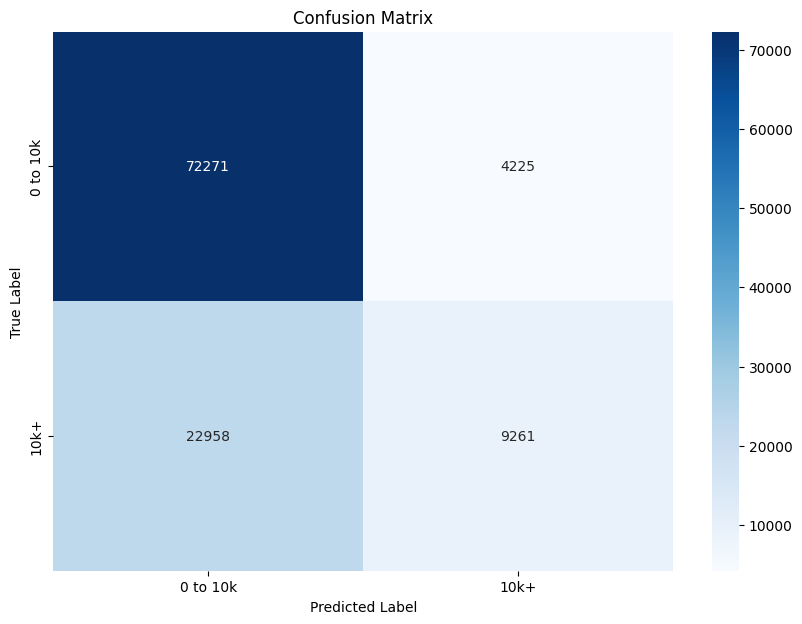

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the predictions and labels from the DataFrame
predictions_and_labels = predictions.select("prediction", "label").rdd.map(lambda row: (row.prediction, row.label))

# Compute the confusion matrix
conf_matrix = confusion_matrix(predictions_and_labels.map(lambda x: x[1]).collect(),
                                predictions_and_labels.map(lambda x: x[0]).collect())

# Get the category names
category_names = ["0 to 10k", "10k+"]

# Convert confusion matrix to DataFrame with category names
conf_df = pd.DataFrame(conf_matrix, index=category_names, columns=category_names)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_df, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Testing Data)")
plt.show()


In [ ]:
# Extract feature names from the VectorAssembler inputCols
feature_metadata = training_data.schema["features"].metadata["ml_attr"]["attrs"]

# Initialize lists to store feature names
numeric_feature_columns = []
string_feature_columns = []
boolean_feature_columns = []

# Loop through the metadata attributes and categorize feature names based on their type
for attr_type, attr_info in feature_metadata.items():
    for attr in attr_info:
        if attr_type == "numeric":
            numeric_feature_columns.append(attr["name"])
        elif attr_type == "nominal":
            string_feature_columns.append(attr["name"])
        elif attr_type == "binary":
            boolean_feature_columns.append(attr["name"])

# Combine all feature columns into a single list
feature_columns = numeric_feature_columns + string_feature_columns + boolean_feature_columns

# Get feature importance
feature_importance = model.featureImportances.toArray()

# Create a list of (feature_name, importance) tuples
indexed_importance = [(feature_columns[i], importance) for i, importance in enumerate(feature_importance)]

# Sort the list by importance (descending)
sorted_importance = sorted(indexed_importance, key=lambda x: x[1], reverse=True)

# Print the feature importance in descending order
print("Feature Importance:")
for feature, importance in sorted_importance:
    print(f"{feature}: {importance}")


Feature Importance:
grouped_genre_index: 0.43713941147058866
contentRating_index: 0.24478534910025215
score: 0.14135640364762195
free_index: 0.14072946317008472
offersIAP_index: 0.021281473783648835
price: 0.009116539662236172
adSupported_index: 0.0055913591655675525


In [ ]:
# Count the number of instances for the "10k+" category in the testing dataset
count_10k_category = testing_data.filter(testing_data["minInstalls_category"] == "10k+").count()

print(count_10k_category)


32219


# Random forest using other parameters

**Random forest with other parameters**

In [ ]:
# Customized parameters
num_trees = 80
max_depth = 10

# Define your RandomForestClassifier
rf = RandomForestClassifier(labelCol="label",
                            featuresCol="features",
                            numTrees=num_trees,
                            maxDepth=max_depth)

# Fit the pipeline to your data
model = rf.fit(training_data)

# Make predictions on the testing data
predictions = model.transform(testing_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Print the accuracy
print("Accuracy: {:.4f}".format(accuracy))

# Calculate precision
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedPrecision"
)
precision = precision_evaluator.evaluate(predictions)

# Calculate recall
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedRecall"
)
recall = recall_evaluator.evaluate(predictions)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))

Accuracy: 0.7506
Precision: 0.7393
Recall: 0.7506
F1-score: 0.7449


In [ ]:
# Get the predictions and labels from the DataFrame
predictions_and_labels = predictions.select("prediction", "label").rdd.map(lambda row: (row.prediction, row.label))

# Compute TP, FP, TN, FN
tp = predictions_and_labels.filter(lambda x: x[0] == 1 and x[1] == 1).count()
fp = predictions_and_labels.filter(lambda x: x[0] == 1 and x[1] == 0).count()
tn = predictions_and_labels.filter(lambda x: x[0] == 0 and x[1] == 0).count()
fn = predictions_and_labels.filter(lambda x: x[0] == 0 and x[1] == 1).count()

# Calculate Accuracy
accuracy = (tp + tn) / (tp + fp + fn + tn)

# Calculate Precision
precision = tp / (tp + fp)

# Calculate Recall
recall = tp / (tp + fn)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))


Accuracy: 0.7506
Precision: 0.6941
Recall: 0.2833
F1-score: 0.4023


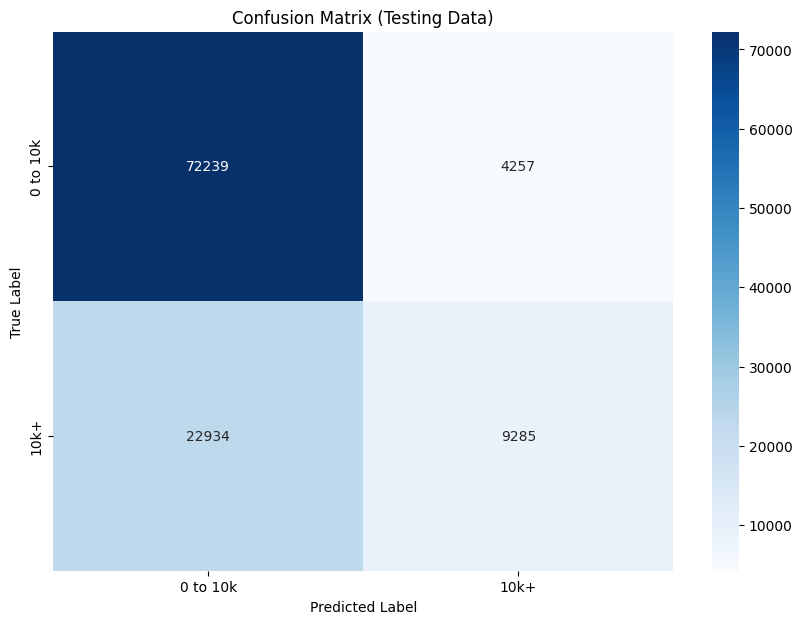

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the predictions and labels from the DataFrame
predictions_and_labels = predictions.select("prediction", "label").rdd.map(lambda row: (row.prediction, row.label))

# Compute the confusion matrix
conf_matrix = confusion_matrix(predictions_and_labels.map(lambda x: x[1]).collect(),
                                predictions_and_labels.map(lambda x: x[0]).collect())

# Get the category names
category_names = ["0 to 10k", "10k+"]

# Convert confusion matrix to DataFrame with category names
conf_df = pd.DataFrame(conf_matrix, index=category_names, columns=category_names)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_df, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Testing Data)")
plt.show()


In [ ]:
# Extract feature names from the VectorAssembler inputCols
feature_metadata = training_data.schema["features"].metadata["ml_attr"]["attrs"]

# Initialize lists to store feature names
numeric_feature_columns = []
string_feature_columns = []
boolean_feature_columns = []

# Loop through the metadata attributes and categorize feature names based on their type
for attr_type, attr_info in feature_metadata.items():
    for attr in attr_info:
        if attr_type == "numeric":
            numeric_feature_columns.append(attr["name"])
        elif attr_type == "nominal":
            string_feature_columns.append(attr["name"])
        elif attr_type == "binary":
            boolean_feature_columns.append(attr["name"])

# Combine all feature columns into a single list
feature_columns = numeric_feature_columns + string_feature_columns + boolean_feature_columns

# Get feature importance
feature_importance = model.featureImportances.toArray()

# Create a list of (feature_name, importance) tuples
indexed_importance = [(feature_columns[i], importance) for i, importance in enumerate(feature_importance)]

# Sort the list by importance (descending)
sorted_importance = sorted(indexed_importance, key=lambda x: x[1], reverse=True)

# Print the feature importance in descending order
print("Feature Importance:")
for feature, importance in sorted_importance:
    print(f"{feature}: {importance}")


Feature Importance:
grouped_genre_index: 0.4380193094893589
contentRating_index: 0.23568299535125878
score: 0.14893175654310958
free_index: 0.1383481781857298
offersIAP_index: 0.02250201891262072
price: 0.008376064634981384
adSupported_index: 0.008139676882940762


# Decision tree using 2 output categories

**Decision Tree for 2 categories**

In [ ]:
# Train a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=12)
dt_model = dt_classifier.fit(training_data)

# Make predictions on the testing data
predictions = dt_model.transform(testing_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Calculate accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print("Accuracy:", accuracy)

# Calculate precision
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
print("Precision:", precision)

# Calculate recall
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
print("Recall:", recall)

# Calculate F1-score
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print("F1-score:", f1_score)

Accuracy: 0.7508531481396311
Precision: 0.7361396735693277
Recall: 0.7508531481396312
F1-score: 0.7181544445874958


In [ ]:
# Get the predictions and labels from the DataFrame
predictions_and_labels = predictions.select("prediction", "label").rdd.map(lambda row: (row.prediction, row.label))

# Compute TP, FP, TN, FN
tp = predictions_and_labels.filter(lambda x: x[0] == 1 and x[1] == 1).count()
fp = predictions_and_labels.filter(lambda x: x[0] == 1 and x[1] == 0).count()
tn = predictions_and_labels.filter(lambda x: x[0] == 0 and x[1] == 0).count()
fn = predictions_and_labels.filter(lambda x: x[0] == 0 and x[1] == 1).count()

# Calculate Accuracy
accuracy = (tp + tn) / (tp + fp + fn + tn)

# Calculate Precision
precision = tp / (tp + fp)

# Calculate Recall
recall = tp / (tp + fn)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))


Accuracy: 0.7509
Precision: 0.6706
Recall: 0.3131
F1-score: 0.4269


In [ ]:
# Extract feature names from the training data
feature_names = assembler.getInputCols()

# Get feature importance
feature_importance = dt_model.featureImportances.toArray()

# Create a list of (feature_index, importance) tuples
indexed_importance = [(i, importance) for i, importance in enumerate(feature_importance)]

# Sort the list by importance (descending)
sorted_importance = sorted(indexed_importance, key=lambda x: x[1], reverse=True)

# Print the feature importance in descending order
print("Feature Importance:")
for i, importance in sorted_importance:
    print(f"Feature '{feature_names[i]}': Importance - {importance}")


Feature Importance:
Feature 'offersIAP_index': Importance - 0.4518660952412785
Feature 'grouped_genre_index': Importance - 0.18294520294908026
Feature 'adSupported_index': Importance - 0.17571189575075755
Feature 'score': Importance - 0.1522776967142977
Feature 'contentRating_index': Importance - 0.019690943026924996
Feature 'free_index': Importance - 0.009005486340134908
Feature 'price': Importance - 0.008502679977526219


# Using different sample split to test generalization and model stability

***Using different sample split ***

In [ ]:
# Split the data into training and testing sets
(training_data, testing_data) = selected_data.randomSplit([0.7, 0.3], seed=5)

In [ ]:
# Customized parameters
num_trees = 50
max_depth = 10

# Define your RandomForestClassifier
rf = RandomForestClassifier(labelCol="label",
                            featuresCol="features",
                            numTrees=num_trees,
                            maxDepth=max_depth)

# Fit the pipeline to your data
model = rf.fit(training_data)

# Make predictions on the testing data
predictions = model.transform(testing_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Print the accuracy
print("Accuracy: {:.4f}".format(accuracy))

# Calculate precision
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedPrecision"
)
precision = precision_evaluator.evaluate(predictions)

# Calculate recall
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedRecall"
)
recall = recall_evaluator.evaluate(predictions)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))

Accuracy: 0.7497
Precision: 0.7354
Recall: 0.7497
F1-score: 0.7425


In [ ]:
# Get the predictions and labels from the DataFrame
predictions_and_labels = predictions.select("prediction", "label").rdd.map(lambda row: (row.prediction, row.label))

# Compute TP, FP, TN, FN
tp = predictions_and_labels.filter(lambda x: x[0] == 1 and x[1] == 1).count()
fp = predictions_and_labels.filter(lambda x: x[0] == 1 and x[1] == 0).count()
tn = predictions_and_labels.filter(lambda x: x[0] == 0 and x[1] == 0).count()
fn = predictions_and_labels.filter(lambda x: x[0] == 0 and x[1] == 1).count()

# Calculate Accuracy
accuracy = (tp + tn) / (tp + fp + fn + tn)

# Calculate Precision
precision = tp / (tp + fp)

# Calculate Recall
recall = tp / (tp + fn)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))


Accuracy: 0.7497
Precision: 0.6754
Recall: 0.2907
F1-score: 0.4065


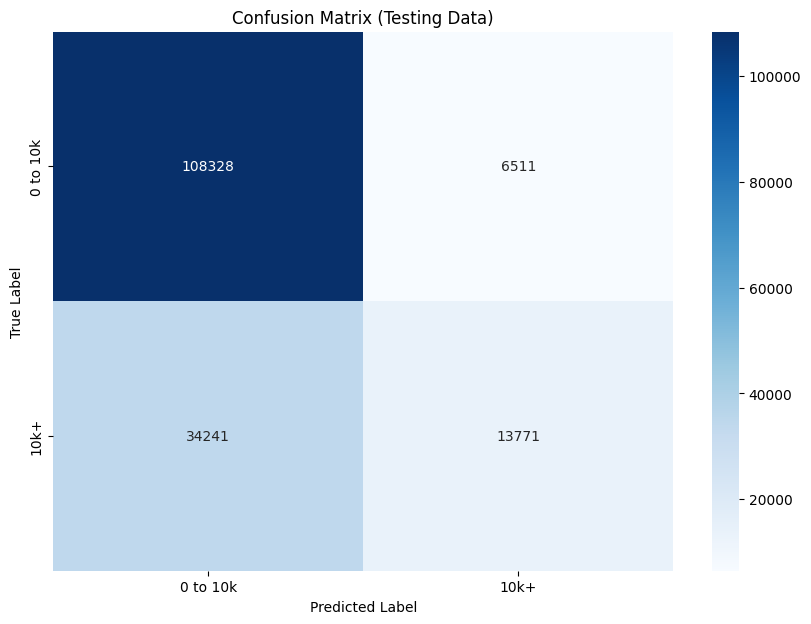

In [ ]:
# Get the predictions and labels from the DataFrame
predictions_and_labels = predictions.select("prediction", "label").rdd.map(lambda row: (row.prediction, row.label))

# Compute the confusion matrix
conf_matrix = confusion_matrix(predictions_and_labels.map(lambda x: x[1]).collect(),
                                predictions_and_labels.map(lambda x: x[0]).collect())

# Get the category names
category_names = ["0 to 10k", "10k+"]

# Convert confusion matrix to DataFrame with category names
conf_df = pd.DataFrame(conf_matrix, index=category_names, columns=category_names)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_df, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Testing Data)")
plt.show()


In [ ]:
# Extract feature names from the VectorAssembler inputCols
feature_metadata = training_data.schema["features"].metadata["ml_attr"]["attrs"]

# Initialize lists to store feature names
numeric_feature_columns = []
string_feature_columns = []
boolean_feature_columns = []

# Loop through the metadata attributes and categorize feature names based on their type
for attr_type, attr_info in feature_metadata.items():
    for attr in attr_info:
        if attr_type == "numeric":
            numeric_feature_columns.append(attr["name"])
        elif attr_type == "nominal":
            string_feature_columns.append(attr["name"])
        elif attr_type == "binary":
            boolean_feature_columns.append(attr["name"])

# Combine all feature columns into a single list
feature_columns = numeric_feature_columns + string_feature_columns + boolean_feature_columns

# Get feature importance
feature_importance = model.featureImportances.toArray()

# Create a list of (feature_name, importance) tuples
indexed_importance = [(feature_columns[i], importance) for i, importance in enumerate(feature_importance)]

# Sort the list by importance (descending)
sorted_importance = sorted(indexed_importance, key=lambda x: x[1], reverse=True)

# Print the feature importance in descending order
print("Feature Importance:")
for feature, importance in sorted_importance:
    print(f"{feature}: {importance}")


Feature Importance:
grouped_genre_index: 0.43008562520426386
contentRating_index: 0.2450465802347558
score: 0.14680411719001055
free_index: 0.14213468376899058
offersIAP_index: 0.02104583192726659
price: 0.00921472735190398
adSupported_index: 0.005668434322808603


In [ ]:
# Customized parameters
num_trees = 80
max_depth = 10

# Define your RandomForestClassifier
rf = RandomForestClassifier(labelCol="label",
                            featuresCol="features",
                            numTrees=num_trees,
                            maxDepth=max_depth)

# Fit the pipeline to your data
model = rf.fit(training_data)

# Make predictions on the testing data
predictions = model.transform(testing_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Print the accuracy
print("Accuracy: {:.4f}".format(accuracy))

# Calculate precision
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedPrecision"
)
precision = precision_evaluator.evaluate(predictions)

# Calculate recall
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedRecall"
)
recall = recall_evaluator.evaluate(predictions)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))

Accuracy: 0.7499
Precision: 0.7359
Recall: 0.7499
F1-score: 0.7428


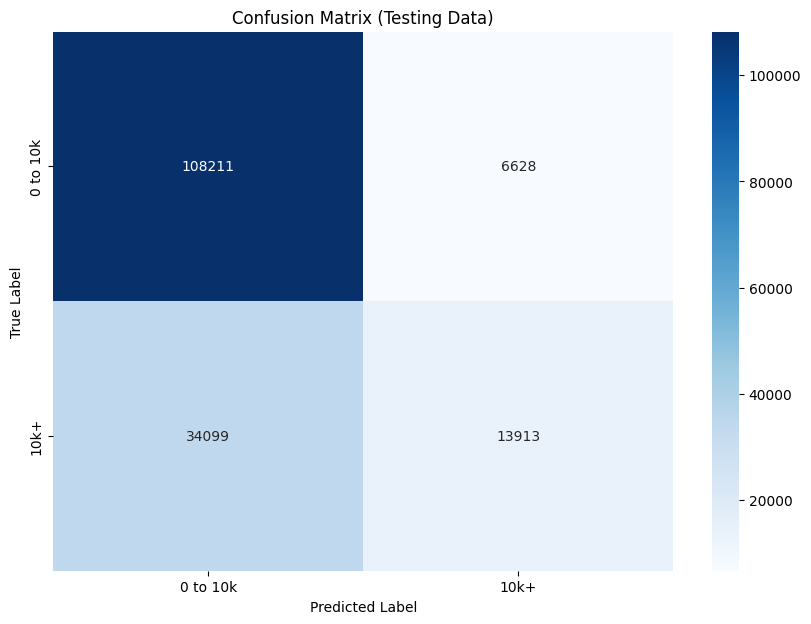

In [ ]:
# Get the predictions and labels from the DataFrame
predictions_and_labels = predictions.select("prediction", "label").rdd.map(lambda row: (row.prediction, row.label))

# Compute the confusion matrix
conf_matrix = confusion_matrix(predictions_and_labels.map(lambda x: x[1]).collect(),
                                predictions_and_labels.map(lambda x: x[0]).collect())

# Get the category names
category_names = ["0 to 10k", "10k+"]

# Convert confusion matrix to DataFrame with category names
conf_df = pd.DataFrame(conf_matrix, index=category_names, columns=category_names)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_df, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Testing Data)")
plt.show()

In [ ]:
# Get the predictions and labels from the DataFrame
predictions_and_labels = predictions.select("prediction", "label").rdd.map(lambda row: (row.prediction, row.label))

# Compute TP, FP, TN, FN
tp = predictions_and_labels.filter(lambda x: x[0] == 1 and x[1] == 1).count()
fp = predictions_and_labels.filter(lambda x: x[0] == 1 and x[1] == 0).count()
tn = predictions_and_labels.filter(lambda x: x[0] == 0 and x[1] == 0).count()
fn = predictions_and_labels.filter(lambda x: x[0] == 0 and x[1] == 1).count()

# Calculate Accuracy
accuracy = (tp + tn) / (tp + fp + fn + tn)

# Calculate Precision
precision = tp / (tp + fp)

# Calculate Recall
recall = tp / (tp + fn)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))


Accuracy: 0.7499
Precision: 0.6773
Recall: 0.2898
F1-score: 0.4059


In [ ]:
# Extract feature names from the VectorAssembler inputCols
feature_metadata = training_data.schema["features"].metadata["ml_attr"]["attrs"]

# Initialize lists to store feature names
numeric_feature_columns = []
string_feature_columns = []
boolean_feature_columns = []

# Loop through the metadata attributes and categorize feature names based on their type
for attr_type, attr_info in feature_metadata.items():
    for attr in attr_info:
        if attr_type == "numeric":
            numeric_feature_columns.append(attr["name"])
        elif attr_type == "nominal":
            string_feature_columns.append(attr["name"])
        elif attr_type == "binary":
            boolean_feature_columns.append(attr["name"])

# Combine all feature columns into a single list
feature_columns = numeric_feature_columns + string_feature_columns + boolean_feature_columns

# Get feature importance
feature_importance = model.featureImportances.toArray()

# Create a list of (feature_name, importance) tuples
indexed_importance = [(feature_columns[i], importance) for i, importance in enumerate(feature_importance)]

# Sort the list by importance (descending)
sorted_importance = sorted(indexed_importance, key=lambda x: x[1], reverse=True)

# Print the feature importance in descending order
print("Feature Importance:")
for feature, importance in sorted_importance:
    print(f"{feature}: {importance}")


Feature Importance:
grouped_genre_index: 0.45959467089891526
contentRating_index: 0.23217239793235694
score: 0.14354277006260394
free_index: 0.12933665426655083
offersIAP_index: 0.019230302336956228
price: 0.009757784987903381
adSupported_index: 0.006365419514713454


# Decision tree using different sample split

In [ ]:
# Train a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=12)
dt_model = dt_classifier.fit(training_data)

# Make predictions on the testing data
predictions = dt_model.transform(testing_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Calculate accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print("Accuracy:", accuracy)

# Calculate precision
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
print("Precision:", precision)

# Calculate recall
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
print("Recall:", recall)

# Calculate F1-score
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print("F1-score:", f1_score)

Accuracy: 0.7496238893221411
Precision: 0.733628658346259
Recall: 0.7496238893221411
F1-score: 0.7164919587565451


In [ ]:
# Get the predictions and labels from the DataFrame
predictions_and_labels = predictions.select("prediction", "label").rdd.map(lambda row: (row.prediction, row.label))

# Compute TP, FP, TN, FN
tp = predictions_and_labels.filter(lambda x: x[0] == 1 and x[1] == 1).count()
fp = predictions_and_labels.filter(lambda x: x[0] == 1 and x[1] == 0).count()
tn = predictions_and_labels.filter(lambda x: x[0] == 0 and x[1] == 0).count()
fn = predictions_and_labels.filter(lambda x: x[0] == 0 and x[1] == 1).count()

# Calculate Accuracy
accuracy = (tp + tn) / (tp + fp + fn + tn)

# Calculate Precision
precision = tp / (tp + fp)

# Calculate Recall
recall = tp / (tp + fn)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))


Accuracy: 0.7496
Precision: 0.6621
Recall: 0.3078
F1-score: 0.4203


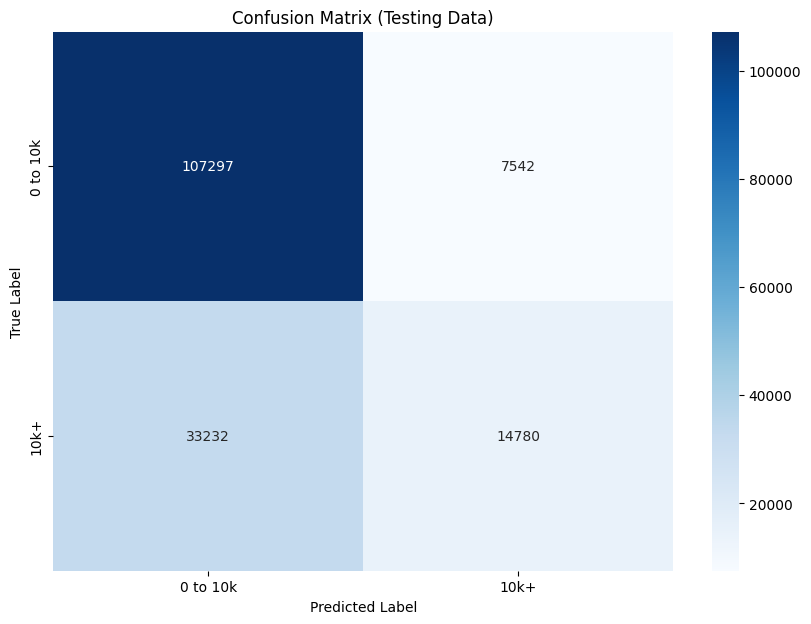

In [ ]:
# Get the predictions and labels from the DataFrame
predictions_and_labels = predictions.select("prediction", "label").rdd.map(lambda row: (row.prediction, row.label))

# Compute the confusion matrix
conf_matrix = confusion_matrix(predictions_and_labels.map(lambda x: x[1]).collect(),
                                predictions_and_labels.map(lambda x: x[0]).collect())

# Get the category names
category_names = ["0 to 10k", "10k+"]

# Convert confusion matrix to DataFrame with category names
conf_df = pd.DataFrame(conf_matrix, index=category_names, columns=category_names)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_df, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Testing Data)")
plt.show()

In [ ]:
# Extract feature names from the training data
feature_names = assembler.getInputCols()

# Get feature importance
feature_importance = dt_model.featureImportances.toArray()

# Create a list of (feature_index, importance) tuples
indexed_importance = [(i, importance) for i, importance in enumerate(feature_importance)]

# Sort the list by importance (descending)
sorted_importance = sorted(indexed_importance, key=lambda x: x[1], reverse=True)

# Print the feature importance in descending order
print("Feature Importance:")
for i, importance in sorted_importance:
    print(f"Feature '{feature_names[i]}': Importance - {importance}")


Feature Importance:
Feature 'offersIAP_index': Importance - 0.45474025536503293
Feature 'grouped_genre_index': Importance - 0.18596558042738337
Feature 'adSupported_index': Importance - 0.17545581825114556
Feature 'score': Importance - 0.1463039873262219
Feature 'contentRating_index': Importance - 0.01937160585838274
Feature 'price': Importance - 0.016544584196886532
Feature 'free_index': Importance - 0.001618168574947132


**End session**

In [ ]:
# Stop Spark session
spark.stop()

# Apple CLean Data

In [10]:
# Define your BigQuery project ID and table ID
project_id = "big-data-analytics-415801"
table_id = 'dev_cleanData.cleanAppleMain'

# SQL query to fetch the data from the table
sql_query = f"SELECT * FROM {table_id}"

# Read data from BigQuery into a DataFrame
appleMain_pdDF = pd.read_gbq(sql_query, project_id=project_id)

In [11]:
pd.set_option('display.max_columns', None)
appleMain_pdDF.head()

,title,description,summary,installs,minInstalls,realInstalls,score,ratings,reviews,price,free,currency,offersIAP,inAppProductPrice,developer,genre,genreId,contentRating,contentRatingDescription,adSupported,released,lastUpdatedOn,version,appId,categories_list,min_inAppProductPrice,max_inAppProductPrice,1starrating_no,2starrating_no,3starrating_no,4starrating_no,5starrating_no
0,Bluetooth Explorer,Explore available bluetooth devices and show d...,None,None,None,None,1.0,None,48.0,3.99,None,USD,None,None,Chris Vallis,Business,None,None,None,None,"Sep 27, 2012",None,None,557468553,None,None,None,100.0,0.0,0.0,0.0,0.0
1,Aqua nAgent,- Proxy Server ê¸°ë° ìí¸í ì»¨í ì¸ ì¬ì...,None,None,None,None,1.0,None,23.0,0.0,None,USD,None,None,"CDNetworks Co., Ltd.",Photo & Video,None,None,None,None,"Apr 16, 2019",None,None,1392120905,None,None,None,100.0,0.0,0.0,0.0,0.0
2,Star Mobile,The Star Mobile Time and Expense app enables p...,None,None,None,None,1.0,None,24.0,0.0,None,USD,None,None,Star Computers Ltd,Business,None,None,None,None,"Jul 13, 2015",None,None,1001182731,None,None,None,100.0,0.0,0.0,0.0,0.0
3,Visualize You: weight change viewer,VISUALIZE YOU\n\nLetâs face it. Losing weigh...,None,None,None,None,1.0,None,47.0,1.99,None,USD,None,None,Visual Health Solutions LLC,Lifestyle,None,None,None,None,"Mar 5, 2015",None,None,971308919,None,None,None,100.0,0.0,0.0,0.0,0.0
4,MobileTech R6.0 for Signature,IMPORTANT: MobileTech R6.0 is compatible with ...,None,None,None,None,1.0,None,35.0,0.0,None,USD,None,None,"WennSoft, LLC",Business,None,None,None,None,"Feb 28, 2018",None,None,1347912120,None,None,None,100.0,0.0,0.0,0.0,0.0


In [13]:
# appleMain_pdDF.to_csv("/content/drive/MyDrive/Colab Notebooks/cleanAppleMain.csv")

# Read CSV files into PySpark DataFrame
appleMain_sparkDF = spark.read.format("csv") \
                    .option("inferSchema", "true") \
                    .option("header", "true") \
                    .option("multiline", "true") \
                    .option("escape", "\"") \
                    .csv("/content/drive/MyDrive/Colab Notebooks/cleanAppleMain.csv")

In [14]:
appleMain_sparkDF.show(10)

+---+--------------------+--------------------+-------+--------+-----------+------------+-----+-------+-------+-----+----+--------+---------+-----------------+--------------------+-------------+-------+-------------+------------------------+-----------+------------+-------------+-------+----------+---------------+---------------------+---------------------+--------------+--------------+--------------+--------------+--------------+
|_c0|               title|         description|summary|installs|minInstalls|realInstalls|score|ratings|reviews|price|free|currency|offersIAP|inAppProductPrice|           developer|        genre|genreId|contentRating|contentRatingDescription|adSupported|    released|lastUpdatedOn|version|     appId|categories_list|min_inAppProductPrice|max_inAppProductPrice|1starrating_no|2starrating_no|3starrating_no|4starrating_no|5starrating_no|
+---+--------------------+--------------------+-------+--------+-----------+------------+-----+-------+-------+-----+----+--------

In [15]:
appleMain_sparkDF.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- installs: string (nullable = true)
 |-- minInstalls: string (nullable = true)
 |-- realInstalls: string (nullable = true)
 |-- score: double (nullable = true)
 |-- ratings: string (nullable = true)
 |-- reviews: double (nullable = true)
 |-- price: string (nullable = true)
 |-- free: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- offersIAP: string (nullable = true)
 |-- inAppProductPrice: string (nullable = true)
 |-- developer: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- genreId: string (nullable = true)
 |-- contentRating: string (nullable = true)
 |-- contentRatingDescription: string (nullable = true)
 |-- adSupported: string (nullable = true)
 |-- released: string (nullable = true)
 |-- lastUpdatedOn: string (nullable = true)
 |-- version: string (nullable = true)
 |-- appId

# EDA

In [25]:
# double check null values
# Define the columns
columns = [
    "title", "description", "summary", "installs", "minInstalls", "realInstalls",
    "score", "ratings", "reviews", "price", "free", "currency", "offersIAP",
    "inAppProductPrice", "developer", "genre", "genreId", "contentRating",
    "contentRatingDescription", "adSupported", "released", "lastUpdatedOn",
    "version", "appId", "categories_list", "min_inAppProductPrice",
    "max_inAppProductPrice", "1starrating_no", "2starrating_no",
    "3starrating_no", "4starrating_no", "5starrating_no"
]

# Define a function to count null values for a specific column
def count_nulls(column_name):
    return appleMain_sparkDF.filter(col(column_name).isNull()).count()

# Use map() to apply the function to each column and create a list of tuples (column_name, null_count)
null_counts = list(map(lambda column_name: (column_name, count_nulls(column_name)), columns))

# Print column names and their corresponding null counts
for col_name, null_count in null_counts:
    print(f"Column '{col_name}' has {null_count} null values.")


Column 'title' has 0 null values.
Column 'description' has 0 null values.
Column 'summary' has 138063 null values.
Column 'installs' has 138063 null values.
Column 'minInstalls' has 138063 null values.
Column 'realInstalls' has 138063 null values.
Column 'score' has 0 null values.
Column 'ratings' has 138063 null values.
Column 'reviews' has 0 null values.
Column 'price' has 0 null values.
Column 'free' has 138063 null values.
Column 'currency' has 0 null values.
Column 'offersIAP' has 138063 null values.
Column 'inAppProductPrice' has 138063 null values.
Column 'developer' has 0 null values.
Column 'genre' has 0 null values.
Column 'genreId' has 138063 null values.
Column 'contentRating' has 138063 null values.
Column 'contentRatingDescription' has 138063 null values.
Column 'adSupported' has 138063 null values.
Column 'released' has 0 null values.
Column 'lastUpdatedOn' has 138063 null values.
Column 'version' has 138063 null values.
Column 'appId' has 0 null values.
Column 'categori

In [26]:
# Check number of distinct values for categorical features

# Define the columns
columns = ['installs', 'developer', 'genre', 'contentRating', 'contentRatingDescription']

# Define a function to count the number of distinct values for a specific column
def count_distinct(column_name):
    return appleMain_sparkDF.select(column_name).distinct().count()

# Use map() to apply the function to each column and create a list of tuples (column_name, distinct_count)
distinct_counts = list(map(lambda column_name: (column_name, count_distinct(column_name)), columns))

# Print column names and their corresponding distinct counts
for col_name, distinct_count in distinct_counts:
    print(f"Column '{col_name}' has {distinct_count} distinct values.")

Column 'installs' has 1 distinct values.
Column 'developer' has 83776 distinct values.
Column 'genre' has 26 distinct values.
Column 'contentRating' has 1 distinct values.
Column 'contentRatingDescription' has 1 distinct values.


In [27]:
# Check distinct values for categorical features

# Define the columns
columns = ['installs', 'genre', 'contentRating', 'contentRatingDescription']

# Define a function to collect all distinct values for a specific column
def get_distinct_values(column_name):
    distinct_values = appleMain_sparkDF.select(column_name).distinct().rdd.map(lambda row: row[0]).collect()
    return column_name, distinct_values

# Use map() to apply the function to each column and create a list of tuples (column_name, distinct_values)
distinct_values_list = list(map(lambda column_name: get_distinct_values(column_name), columns))

# Print column names and their corresponding distinct values
for col_name, distinct_values in distinct_values_list:
    print(f"Column '{col_name}' has distinct values:")
    for value in distinct_values:
        print(value)
    print()  # Print an empty line for better readability

Column 'installs' has distinct values:
None

Column 'genre' has distinct values:
Education
Navigation
Entertainment
Sports
Food & Drink
Photo & Video
Graphics & Design
Travel
Finance
Social Networking
Shopping
Reference
Health & Fitness
Books
Magazines & Newspapers
Utilities
Productivity
Games
Music
Lifestyle
Business
Developer Tools
Weather
Medical
Stickers
News

Column 'contentRating' has distinct values:
None

Column 'contentRatingDescription' has distinct values:
None



# Group top 20 genres and install categories

In [19]:
# Get the top 20 genres based on frequency
top_genres = appleMain_sparkDF.groupBy("genre").count().orderBy(col("count").desc()).limit(20)

# Collect the top 20 genres as a list
top_genre_list = top_genres.select("genre").rdd.flatMap(lambda x: x).collect()

# Create a new column 'grouped_genre' where top genres are kept and others are replaced with 'Others'
appleMain_sparkDF_with_grouped_genre = appleMain_sparkDF.withColumn("grouped_genre",
    when(col("genre").isin(top_genre_list), col("genre")).otherwise("Others")
)

# Show the DataFrame with the grouped genre column
appleMain_sparkDF_with_grouped_genre.select("genre", "grouped_genre").show()


+-------------+-------------+
|        genre|grouped_genre|
+-------------+-------------+
|     Business|     Business|
|Photo & Video|Photo & Video|
|     Business|     Business|
|    Lifestyle|    Lifestyle|
|     Business|     Business|
|Photo & Video|Photo & Video|
|Photo & Video|Photo & Video|
| Productivity| Productivity|
|    Education|    Education|
|Photo & Video|Photo & Video|
|     Business|     Business|
|      Medical|      Medical|
|   Navigation|   Navigation|
|      Finance|      Finance|
|     Business|     Business|
|        Games|        Games|
|        Games|        Games|
|    Utilities|    Utilities|
| Productivity| Productivity|
|    Education|    Education|
+-------------+-------------+
only showing top 20 rows



In [20]:
print(top_genre_list)

['Games', 'Education', 'Utilities', 'Business', 'Lifestyle', 'Health & Fitness', 'Productivity', 'Finance', 'Entertainment', 'Shopping', 'Food & Drink', 'Photo & Video', 'Travel', 'Sports', 'Music', 'Social Networking', 'Medical', 'Reference', 'News', 'Navigation']


In [21]:
# Try to group into top 6 categories

# Define the categories and their thresholds
categories = {
    '0 to 1k': (0, 1000),
    '1k+ to 5k': (1001, 5000),
    '5k+ to 10k+': (5001, 10000),
    '10k+ to 50k': (10001, 50000),
    '50k+ to 100k': (50001, 100000),
    '100k+' : (100001, float('inf'))
}

# Create a case expression to map numeric installs to category labels
case_expr = (
    F.when((F.col('minInstalls') >= lower) & (F.col('minInstalls') <= upper), category)
    for category, (lower, upper) in categories.items()
)

In [22]:
# Apply the case expression to create the new column 'minInstalls_category'
appleMain_sparkDF_v2 = appleMain_sparkDF_with_grouped_genre.withColumn(
    'minInstalls_category',
    F.coalesce(*case_expr, F.lit('Others'))
)

In [24]:
appleMain_sparkDF_v2.show(1)

+---+------------------+--------------------+-------+--------+-----------+------------+-----+-------+-------+-----+----+--------+---------+-----------------+------------+--------+-------+-------------+------------------------+-----------+------------+-------------+-------+---------+---------------+---------------------+---------------------+--------------+--------------+--------------+--------------+--------------+-------------+--------------------+
|_c0|             title|         description|summary|installs|minInstalls|realInstalls|score|ratings|reviews|price|free|currency|offersIAP|inAppProductPrice|   developer|   genre|genreId|contentRating|contentRatingDescription|adSupported|    released|lastUpdatedOn|version|    appId|categories_list|min_inAppProductPrice|max_inAppProductPrice|1starrating_no|2starrating_no|3starrating_no|4starrating_no|5starrating_no|grouped_genre|minInstalls_category|
+---+------------------+--------------------+-------+--------+-----------+------------+-----

In [23]:
# Define the categories and their thresholds
categories = {
    '0 to 1k': (0, 1000),
    '1k+ to 5k': (1001, 5000),
    '5k+ to 10k+': (5001, 10000),
    '10k+ to 50k': (10001, 50000),
    '50k+ to 100k': (50001, 100000),
    '100k+': (100001, float('inf'))
}

# Define a function to get the lower threshold for sorting
def get_lower_threshold(category):
    return categories[category][0]

# Group by the 'minInstalls_category' column and count the number of items
category_counts = (appleMain_sparkDF_v2
                   .groupBy('minInstalls_category')
                   .count()
                   .orderBy(F.udf(get_lower_threshold)('minInstalls_category'))
                   )

# Show the results
category_counts.show()


PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "<ipython-input-23-44b316028d4b>", line 13, in get_lower_threshold
KeyError: 'Others'


In [ ]:
# Convert DataFrame to Pandas for sorting
category_counts_pd = category_counts.toPandas()

# Sort the categories based on the lower threshold
category_counts_pd['sort_key'] = category_counts_pd['minInstalls_category'].apply(get_lower_threshold)
category_counts_pd_sorted = category_counts_pd.sort_values(by='sort_key')

# Define the total count
total_count = category_counts_pd['count'].sum()

# Plot the histogram
plt.figure(figsize=(10, 6))
bars = plt.bar(category_counts_pd_sorted['minInstalls_category'], category_counts_pd_sorted['count'], color='skyblue')
plt.xlabel('Installs Category')
plt.ylabel('Count')
plt.title('Number of Items in Each Installs Category')
plt.xticks(rotation=45)
# Annotate each bar with count and percentage
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_count) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}\n({percentage:.2f}%)',
             ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()